In [45]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML


'''emphasize titles'''
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy

In [7]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

desired_videos =['zWg7U0OEAoE']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [8]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa',
    'MIT6_042JF10_notes':'MIT6_042JF10_notes'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter',
    'MIT6_042JF10_notes':'Chapter'
}



In [9]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

In [10]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [11]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

#paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
main_section_as_one_doc = {}
paper_subsec_as_one_doc = {}
first_dep_section_as_one_doc = {}

def get_sub_titles(all_titles,main_tl_indexes):
    subsec_mainchapter_indexes = [range(main_tl_indexes[index],main_tl_indexes[index + 1])
                                  for index in range(len(main_tl_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(main_tl_indexes[-1],len(all_titles)))
    return subsec_mainchapter_indexes


for doc_name in paper_content.keys():
    '''
        first element array of subtitles by dividing based on main chapters like 4 number theory
        second element array of subtitles by dividing based on main first hierarchy depth titles like 4.1 simple graph 
    '''
    titles_by_hierchy_ranges = [] 
    titles_by_hierchy_indexes = []
    
    '''Find the main chapter indexes in the list of the overall titles'''
    '''Titles like 4 Number theory or 5 Graphs'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    titles_by_hierchy_indexes.append(mainchapter_indexes)
    
    '''
        Find the indexes of the first depth subsection
        for example 4.1 simple graphs
    '''
    tl_first_dep_by_hier_indexes = [i for i,tl in enumerate(paper_content[doc_name]['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    titles_by_hierchy_indexes.append(tl_first_dep_by_hier_indexes)
    
    tl_first_dep_by_hier = [tl for i,tl in enumerate(paper_content[doc_name]['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    '''Adding the indexes of the first dep subsections to the main indexes'''
    '''For example the fourth place will contains the indexes of the titles: 4.1,4.2,4.3'''
    top_maintitle_ranges = []

    for index in range(len(mainchapter_indexes) - 1):
        j = mainchapter_indexes[index]
        range_j = []
        while j < mainchapter_indexes[index + 1]:
            '''If this title is from the shape like 4.1 or 4.2'''
            curr_tl = paper_content[doc_name]['titles'][j]
            if j in tl_first_dep_by_hier_indexes:
                range_j.append(tl_first_dep_by_hier.index(curr_tl))
            j+=1
        top_maintitle_ranges.append(range_j)
    '''Adding the last one'''
    j = mainchapter_indexes[-1]
    range_j = []
    while j < len(paper_content[doc_name]['titles']):
        curr_tl = paper_content[doc_name]['titles'][j]
        if j in tl_first_dep_by_hier_indexes:
            range_j.append(tl_first_dep_by_hier.index(curr_tl))
        j+=1
    top_maintitle_ranges.append(range_j)
        
    titles_by_hierchy_ranges.append(top_maintitle_ranges)
    
    '''adding the ranges of the subtitles of the first depth of each '''
    '''like for example for title 4.1 the range will be the indexes of the titles
        4.1.1,4.1.2 etc'''
    titles_by_hierchy_ranges.append(get_sub_titles(paper_content[doc_name]['titles'],
                                                             titles_by_hierchy_indexes[1]))
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a atomic section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    
    
    '''Sections are like 4.1 simple graph'''
    first_dep_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   paper_subsec_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[1]]

    
    '''Union all the sub section in a main chapter into one document'''
    '''sections are like 4 Number theory'''
    main_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   first_dep_section_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[0]]
    

In [13]:
paper_phrasers = {}
for doc_name in main_section_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in main_section_as_one_doc[doc_name]])))

# The Algorithm 

In general, Try to find the topic shifts throw comparing sliding window(sd) to the book chapters

1. for each sliding window (parameritize by step size and windows size):
    0. for simlicity let's pretend we are making the majority vote on the right chapter(since if we will try to find the cosine similarity between the second depth hierarchy chapters we will loose preciseness)
    1. compare each sd to subchapter (second depth level like 4.1) by cosine (creating a vector). in such a way that each block is represented as a vector where each component is the cosine similarity of that particular block to that current sub chapter
    2. find delimeter between the blocks ** -  we use here by finding minimum by comparing the cosine similarity between adjacent blocks vectors
    3. each bunch of blocks is given a label in the second hierarchy level
    4. within each bunch of blocks:
        4.1 create a vector by comparing each block in the current set to the sub chapters from third level of heirarchy in the given labeled first dep chapter. for example blocks 1-5 are assigned to 4.2 so try to set a label for each block from the following (4.2.1,4.2.2 and etc)
        4.2 find minimas and delimeter by them the sub blocks
        4.3 give to each sub block third heirarchy level label (like for block 3 give 4.2.1)
2. for the given delimiteration optimize the parameters using bayesian optimization
    
** the delimeration could base on spectral clustering or finding local minimum between the sd

** find correlation by max or other techniqes

*** maybe when you go down in the hierarchy lower the step size and the sliding window to get granular results. you must give the main chapter selection base on the slidnig window (not by majority) for generalization.

**** notice and make the correlation when topic is shifts and it's correlations values . currently it's always taking the max correlated. like in the videos in the section 6.3.3 it moves to 6.3.1 but according to the blue graph it don't have to ! the diffrence between the blocks vector is minor


In [14]:
import time    
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return time.strftime('%H:%M:%S', time.gmtime(seconds))

In [15]:
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [16]:
df_tp_to_ch = pd.read_csv(os.path.join(groundbase_dir,'Topic to chapter.csv'))
df_tp_to_ch  = df_tp_to_ch.replace({np.nan:None})

In [17]:
def get_corr_chapters_blocks(blocks,titles,section_as_one_doc,
                             dom_main_cha_index=None,hierarchy_level=0):

    '''Yielding the Right paper sections'''
    # if it is not the main chapters
    if dom_main_cha_index is not None: 
        subsection_texts = [section_as_one_doc[s_i]
                           for s_i in titles_by_hierchy_ranges[hierarchy_level][dom_main_cha_index]]
        subsection_titles = [titles[tl_i]
                             for tl_i in titles_by_hierchy_ranges[hierarchy_level][dom_main_cha_index]]
    else:# if it is the main chapters
        subsection_texts = section_as_one_doc
        subsection_titles = titles
    subsection_texts = emphasize_title(paper_name,subsection_texts,subsection_titles,lemmatizing = lemmatizing_method)
    
    #########################################################
    '''Compare between the sliding windows to the chapters'''
    #########################################################
    '''Creating Dictionary and doc2bow'''
    raw_book_video = []
    for sd in blocks:
        raw_book_video = raw_book_video + [sd]    
    for ch in subsection_texts:
        raw_book_video = raw_book_video + [ch]
    the_dictionary = Dictionary(raw_book_video)
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in subsection_texts]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in blocks]
    
    '''Finding Correlation vectors'''
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,dictionary=the_dictionary)
    tf_idf_model_vid = models.TfidfModel(bgw_vids,dictionary=the_dictionary)
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    
    
    # normalizing the correlation between each block and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    
    '''Find the chapter that is most correlated to the block'''
    ch_matching_top = []    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        founded_title = subsection_titles[corr.index(max_cor)]
        ch_matching_top.append((founded_title,corr.index(max_cor)))
    
    return ch_matching_top,np.array(correlation)

In [21]:
def find_dominent_main_chapter(ch_tp_corr,titles,correlation):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr = pd.DataFrame.from_records(correlation)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first > second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])

################ zWg7U0OEAoE ################
main chapters selected:
[('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Sorting', 7), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Introduction', 0), ('Sorting', 7), ('Sorting', 7), ('Heap', 3)]
By the majority vote, the dominent chapter choosed is Introductio

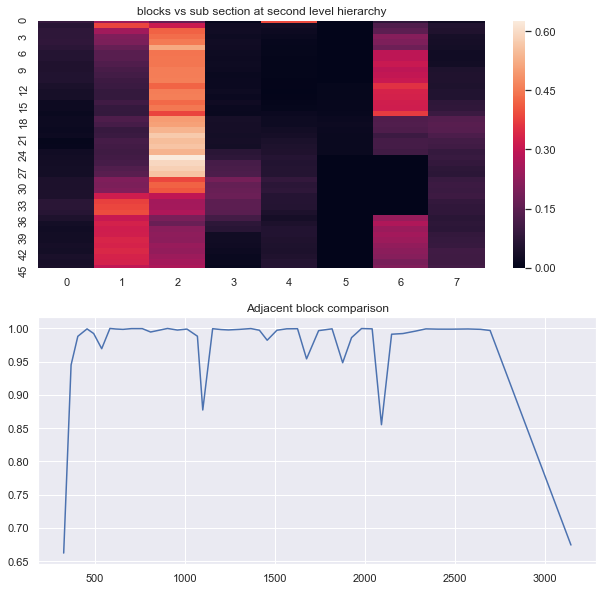

In [31]:
# selected by the majority like in previous notebooks
main_chapters_ = {
    "bTyxpoi2dmM":5,
    "GJpt_3ie4WU":4,
    "h9wxtqoa1jY":4,
    "NuY7szYSXSw":3,
    "XX7ePR21Ook":3,
    'zWg7U0OEAoE':0
} 
paper_name = 'Dsa'
is_print_mess = True
hierarchy_desc = ['first','second','third']

division_results = {}


for vid in videos_ids:
    # PARAMETERS
    window_size =500
    step_size = 40
    df_vid_division = pd.DataFrame(columns=['Title','Start','End'])
    print('################ %s ################' % (vid))
        
    '''Dividing the video transcripts to blocks'''
    block_handler = CreateBlocks(transcripts_jsons[vid])
    blocks = block_handler.partion(method='sliding_window',
                                   window_size=window_size,
                                   step_size_sd=step_size)
    gap_timestamp = block_handler.get_block_gap_timestamp()
    
    ch_main_matching_top,correlation = get_corr_chapters_blocks(blocks,
                                                                paper_content[paper_name]['main titles'],
                                                           main_section_as_one_doc[paper_name]
                                                           )
    
    main_matching_topic = [ch[0] for ch in ch_main_matching_top]
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation)
    print('main chapters selected:')
    print(ch_main_matching_top)
    print('By the majority vote, the dominent chapter choosed is %s ' %(dominet_chapter))
    
    #################################################################
    '''Second heirarchy level comparison'''
    ##################################################################
    '''Find correlation between the corrent chapters to the blocks'''
    hierarchy_level = 0
    dom_main_cha_index = [ch[1] for ch in ch_main_matching_top if ch[0] == dominet_chapter][0] # shortcut for implementing a majority vote
    ch_matching_top,correlation = get_corr_chapters_blocks(blocks,tl_first_dep_by_hier,
                                                           first_dep_section_as_one_doc[paper_name],
                                                           dom_main_cha_index= dom_main_cha_index,
                                                           hierarchy_level=hierarchy_level)
    self_corr = cosine_similarity(correlation,correlation)
    '''Plotting'''
    fig,ax = plt.subplots(2,1,figsize=(10,10))
    
    sns.heatmap(correlation,vmin=np.min(correlation),vmax=np.max(correlation),ax=ax[0])
    ax[0].set_title('blocks vs sub section at %s level hierarchy' %(hierarchy_desc[hierarchy_level +1]))
    
    #sns.heatmap(self_corr,vmin=np.min(self_corr),vmax=np.max(self_corr),ax=ax[1])
    #ax[1].set_title('Self Correlation')
    sequential_values = [self_corr[row,row+1] for row in range(self_corr.shape[0] -1)]
    
    #ax[1].plot(list(map(sec_to_min, gap_timestamp)),sequential_values)
    ax[1].plot(gap_timestamp,sequential_values)
    ax[1].set_title('Adjacent block comparison')
    plt.show()
    
    #[print(str(ch_) + " " + str(g_)) for g_,ch_ in zip(gap_timestamp,ch_matching_top)]
    
    #################################################################
    '''Third heirarchy level comparison'''
    ##################################################################
    gap_timestamp_with_end = gap_timestamp.copy()
    gap_timestamp_with_end.append(df_videos.loc[df_videos['video id'] == vid,
                                                'topic shifts(ends)'].values.tolist()[-1])
    
    
    
    #ch_matching_top_titles = [ch[0] for ch in ch_matching_top]
    
    ''' Initiate parameters and Zakif'''
    curr_topic_blocks = [blocks[0]]
    last_shift_seconds = 0
    ch_matching_top.append(('end',-100)) # zakif
    blocks.append([]) # zakif
    '''Find the shifts where in the second hierarchy level it occurs'''
    for tl_i in range(1,len(ch_matching_top)):
        # if it is the same topic
        if  ch_matching_top[tl_i] == ch_matching_top[tl_i-1]:
            #print("continue first dep heirarchy title : "  + str(ch_matching_top[tl_i]))
            curr_topic_blocks.append(blocks[tl_i])
            
        else:
            #print("new first dep heirarchy title : "  + str(ch_matching_top[tl_i]))
            ''' if we have topic shift '''
            #print(past_chapters[-1])
            #print(past_chapters[-1][1])
            dom_main_cha_index = tl_first_dep_by_hier.index(ch_matching_top[tl_i-1][0])
            #print(dom_main_cha_index)
            sub_ch_matching_top,sub_ch_correlations = get_corr_chapters_blocks(curr_topic_blocks,
                                                                               paper_content[paper_name]['titles'],
                                                                               paper_subsec_as_one_doc[paper_name],
                                                                               dom_main_cha_index=dom_main_cha_index,
                                                                                   hierarchy_level=1)
            #print('sub_ch_matching_top len: %s, curr_topic_blocks len %s '
            #      %(len(sub_ch_matching_top),len(curr_topic_blocks) ))
            
            sub_ch_matching_top.append(('end',-100))
            '''try to find where the subtopic shifts'''
            for sub_ch_i in range(1,len(sub_ch_matching_top)):
                '''Sub topic shift'''
                if sub_ch_matching_top[sub_ch_i] != sub_ch_matching_top[sub_ch_i-1]:
                    end_ = gap_timestamp_with_end[tl_i - len(sub_ch_matching_top) + sub_ch_i]
             #       print('switching subtopic from ' + 
             #             str(sub_ch_matching_top[sub_ch_i -1 ]) + 
             #              ' to ' + str(sub_ch_matching_top[sub_ch_i]))
             #       print('start : %s end %s '%(last_shift_seconds,end_))
                    next_sec  = {
                        'Title': sub_ch_matching_top[sub_ch_i - 1][0],
                         'Start': last_shift_seconds,
                         'End':end_
                    }
                    df_vid_division = df_vid_division.append(next_sec,ignore_index=True)
                    last_shift_seconds = end_
            
            curr_topic_blocks = [blocks[tl_i]]
    #division_results[vid]  = df_vid_division
    #display(HTML(df_vid_division.to_html()))
    df_results = pd.DataFrame(columns=['shift','most_correlated_chapter'])
    df_results['shift'] = df_vid_division['End']
    df_results['most_correlated_chapter'] = df_vid_division['Title']

    

In [32]:
df_vid_division

,Title,Start,End
0,1.5\tBook outline,0,327.000
1,1.2.1\tBig Oh notation,327,368.075
2,1.3\tPseudocode,368.075,1876.335
3,1.2.1\tBig Oh notation,1876.34,3144.230
4,1.2.3\tObject oriented concepts,3144.23,3210.000


# Comparing to groundbase

In [37]:
df_google_form = pd.read_csv('../data/raw/forms/form-answers-poc.csv')
mycolumns = [
             '00:00-04:06','04:06-06:55','06:55-08:54',
             '08:54-10:39','10:39-13:03','13:03-14:56',
             '14:56-17:42','17:42-22:09','22:09-24:41',
             '24:41-27:11','27:11-30:18','30:18-33:39',
             '33:39-38:24','38:24-41:42','41:42-45:20',
             '45:20-49:47','49:47-52:52','52:52-53:30',
             'rating_00:00-04:06','rating_04:06-06:55','rating_06:55-08:54',
             'rating_08:54-10:39','rating_10:39-13:03','rating_13:03-14:56',
             'rating_14:56-17:42','rating_17:42-22:09','rating_22:09-24:41',
             'rating_24:41-27:11','rating_27:11-30:18','rating_30:18-33:39',
             'rating_33:39-38:24','rating_38:24-41:42','rating_41:42-45:20',
             'rating_45:20-49:47','rating_49:47-52:52','rating_52:52-53:30'
            ]
df_google_form = df_google_form.drop(columns=['מבין הפרקים הבאים, איזה אחד הכי מתאים לטווח הזמנים: 00:00-04:06 בסרטון'
                                              ,'חותמת זמן','Unnamed: 20'])
df_google_form.columns = mycolumns
df_google_form.columns

Index(['00:00-04:06', '04:06-06:55', '06:55-08:54', '08:54-10:39',
       '10:39-13:03', '13:03-14:56', '14:56-17:42', '17:42-22:09',
       '22:09-24:41', '24:41-27:11', '27:11-30:18', '30:18-33:39',
       '33:39-38:24', '38:24-41:42', '41:42-45:20', '45:20-49:47',
       '49:47-52:52', '52:52-53:30', 'rating_00:00-04:06',
       'rating_04:06-06:55', 'rating_06:55-08:54', 'rating_08:54-10:39',
       'rating_10:39-13:03', 'rating_13:03-14:56', 'rating_14:56-17:42',
       'rating_17:42-22:09', 'rating_22:09-24:41', 'rating_24:41-27:11',
       'rating_27:11-30:18', 'rating_30:18-33:39', 'rating_33:39-38:24',
       'rating_38:24-41:42', 'rating_41:42-45:20', 'rating_45:20-49:47',
       'rating_49:47-52:52', 'rating_52:52-53:30'],
      dtype='object')

In [43]:
df_google_form

,00:00-04:06,04:06-06:55,06:55-08:54,08:54-10:39,10:39-13:03,13:03-14:56,14:56-17:42,17:42-22:09,22:09-24:41,24:41-27:11,...,rating_22:09-24:41,rating_24:41-27:11,rating_27:11-30:18,rating_30:18-33:39,rating_33:39-38:24,rating_38:24-41:42,rating_41:42-45:20,rating_45:20-49:47,rating_49:47-52:52,rating_52:52-53:30
0,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.3 Pseudocode,1.3 Pseudocode,1.2.2 Imperative programming language,...,2,2,1,1,4,4,4,4,4,3
1,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,4,3,4,4,1,5,4,4,4,5
2,1.5 Book outline,1.2.1 Big Oh notation,1.6 Testing,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.3 Pseudocode,1.2.1 Big Oh notation,1.6 Testing,1.6 Testing,...,4,3,3,3,5,5,5,5,4,4
3,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,1.4 Tips for working through the examples,...,1,1,1,1,2,2,1,2,2,2
4,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,...,2,1,3,2,5,5,5,4,2,2
5,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.2.3. Object oriented concepts,1.3 Pseudocode,1.2.1 Big Oh notation,...,3,3,3,3,3,3,4,4,4,3
6,"1.1 What this book is, and what it isn’t",1.2.1 Big Oh notation,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.4 Tips for working through the examples,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,4,4,5,5,5,5,5,5,5,4
7,"1.1 What this book is, and what it isn’t","1.1 What this book is, and what it isn’t",1.3 Pseudocode,1.3 Pseudocode,1.3 Pseudocode,1.6 Testing,1.6 Testing,1.6 Testing,1.2.1 Big Oh notation,1.2.1 Big Oh notation,...,3,3,4,4,5,5,5,5,5,4


In [40]:
chapters_most_frequent

[['1.1 What this book is, and what it isn’t'],
 ['1.2.1 Big Oh notation'],
 ['1.3 Pseudocode'],
 ['1.3 Pseudocode'],
 ['1.3 Pseudocode'],
 ['1.3 Pseudocode', '1.4 Tips for working through the examples'],
 ['1.3 Pseudocode'],
 ['1.4 Tips for working through the examples'],
 ['1.4 Tips for working through the examples'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.2.1 Big Oh notation'],
 ['1.8 Final messages']]

In [63]:
questions = list(filter(lambda x: "rating" not in x,df_google_form.columns))
rating_confidence = list(filter(lambda x: "rating" in x,df_google_form.columns))
chapters_most_frequent = [df_google_form[col].mode().values.tolist() for col in questions]
ratings_avg = [df_google_form[col].mean() for col in rating_confidence]
ratings_var = [df_google_form[col].var() for col in rating_confidence]
df_results = pd.DataFrame()
df_results['most corr labeled chapters'] = chapters_most_frequent
df_results['labeled num choices'] = [len(df_google_form[col].value_counts()) for col in questions]
df_results['max entropy'] = [np.log2(len(df_google_form[col].value_counts())) for col in questions]
df_results['labeled choose entropy'] = [entropy(df_google_form[col].value_counts(normalize=True),base=2) for col in questions]
df_results['ranges'] = questions
start_segments_seconds = []
end_segments_seconds = []
'''Finding the ranges in seconds for each segment'''
for q in questions:
    '''Convert start and time to seconds'''
    start_seg = q.split('-')[0]
    end_seg = q.split('-')[1]
    start_segments_seconds.append(int(start_seg.split(':')[0]) * 60 + int(start_seg.split(':')[1]))
    end_segments_seconds.append(int(end_seg.split(':')[0]) * 60 + int(end_seg.split(':')[1]))
    
df_results['Start Segment'] = start_segments_seconds
df_results['End Segment'] = end_segments_seconds

'''Find the chapter that fit to each segment selected by the algorithm'''
previous_shift = 0
shifts = df_vid_division['End'].values.tolist()
shifts.insert(0,0)
segments_chapters = []
for topic_i,topic in df_results.iterrows():
    #max_cor = max(corr) # max correlation with that topic

    #print(groundbase)
    curr_shift = topic['End Segment']
    intermax_grb_previous_index = 0
    intermax_grb_next_index = 1
    captured_title = df_vid_division.iloc[intermax_grb_next_index - 1]["Title"]
    max_intersection = min(curr_shift,shifts[intermax_grb_next_index]) - max(previous_shift,shifts[intermax_grb_previous_index])
    for grb_previous_index,grb_next_index in zip(range(0,len(shifts) - 1,1),range(1,len(shifts),1)):
        upper_bound = min(curr_shift,shifts[grb_next_index])
        bottom_bound = max(previous_shift,shifts[grb_previous_index])
        curr_intersection =  upper_bound- bottom_bound
        if  curr_intersection > max_intersection:
            '''print("topic_i : " + str(topic_i)+ " groundbase[grb_previous_index] : " +str(groundbase[grb_previous_index])+
                  " groundbase[grb_next_index]: " +str(groundbase[grb_next_index]) + ' previous_shift : ' +str(previous_shift)+
                 " curr_shift: " +str(curr_shift)  + 'upper_bound : ' + str(upper_bound) + " bottom_bound: " + str(bottom_bound))
            print('curr_intersection ' +str(curr_intersection) + 'max_intersection ' + str(max_intersection))'''
            intermax_grb_previous_index = grb_previous_index
            intermax_grb_next_index = grb_next_index
            max_intersection = curr_intersection
            captured_title = df_vid_division.iloc[intermax_grb_next_index - 1]["Title"]

    segments_chapters.append(captured_title)

    previous_shift = curr_shift


df_results['most_correlated_chapter'] = segments_chapters
df_results

,most corr labeled chapters,labeled num choices,max entropy,labeled choose entropy,ranges,Start Segment,End Segment,most_correlated_chapter
0,"[1.1 What this book is, and what it isn’t]",2,1.000000,0.543564,00:00-04:06,0,246,1.5\tBook outline
1,[1.2.1 Big Oh notation],2,1.000000,0.954434,04:06-06:55,246,415,1.5\tBook outline
2,[1.3 Pseudocode],4,2.000000,1.905639,06:55-08:54,415,534,1.3\tPseudocode
3,[1.3 Pseudocode],1,0.000000,0.000000,08:54-10:39,534,639,1.3\tPseudocode
4,[1.3 Pseudocode],1,0.000000,0.000000,10:39-13:03,639,783,1.3\tPseudocode
5,"[1.3 Pseudocode, 1.4 Tips for working through ...",3,1.584963,1.561278,13:03-14:56,783,896,1.3\tPseudocode
6,[1.3 Pseudocode],3,1.584963,1.405639,14:56-17:42,896,1062,1.3\tPseudocode
7,[1.4 Tips for working through the examples],5,2.321928,2.155639,17:42-22:09,1062,1329,1.3\tPseudocode
8,[1.4 Tips for working through the examples],4,2.000000,1.905639,22:09-24:41,1329,1481,1.3\tPseudocode
9,[1.2.1 Big Oh notation],4,2.000000,1.548795,24:41-27:11,1481,1631,1.3\tPseudocode


In [65]:
df_vid_division

,Title,Start,End
0,1.5\tBook outline,0,327.000
1,1.2.1\tBig Oh notation,327,368.075
2,1.3\tPseudocode,368.075,1876.335
3,1.2.1\tBig Oh notation,1876.34,3144.230
4,1.2.3\tObject oriented concepts,3144.23,3210.000


In [64]:
def hit_ratio(founded_section,labeled_section):
    print('founded_section : %s labeled_section : %s '%(founded_section,labeled_section))
    founded_subsection_nums = founded_section.split('.')
    labeled_subsection_nums = labeled_section.split('.')
    k = min(len(founded_subsection_nums),len(labeled_subsection_nums))
    sub_ratios = []
    for level in range(k):
        my_log = np.log(abs(int(founded_subsection_nums[level]) - int(labeled_subsection_nums[level]) + 1))
        sub_ratios.append(1/((my_log +1) **(level + 1)))
    return sum(sub_ratios)/k

'''Calculate grade for each video matching '''

founded_titles = df_results['most_correlated_chapter'].values.tolist()
founded_sections = list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],founded_titles))
labeled_titles = df_results['most corr labeled chapters'].values.tolist()
labeled_sections = [] #list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],labeled_titles))
for lb_tl_list in labeled_titles:
    labeled_sections.append(list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],lb_tl_list)))

epsilon = 0.00001
normalized_entropy = np.array(list(map(lambda x,y: round(x/(y + epsilon),2),
                                       df_results['labeled choose entropy'].values.tolist(),
                                       df_results['max entropy'].values.tolist())))
cos_normalized_entropy = list(map(lambda x: np.cos(x/180 * np.pi),normalized_entropy))

hit_rates_mult_cos_ent = 0
for found,labels,cos_ent in zip(founded_sections,labeled_sections,cos_normalized_entropy):
    hit_rates_mult_cos_ent += max([hit_ratio(found,lb) * cos_ent for lb in labels])

normalized_factor = sum(list(map(lambda x: np.cos((1/(1+np.exp(-x)))/180 * np.pi),normalized_entropy)))
print(hit_rates_mult_cos_ent/normalized_factor)


founded_section : 1.5 labeled_section : 1.1 
founded_section : 1.5 labeled_section : 1.2.1 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.3 labeled_section : 1.3 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.3 labeled_section : 1.4 
founded_section : 1.3 labeled_section : 1.2.1 
founded_section : 1.3 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.1 labeled_section : 1.2.1 
founded_section : 1.2.3 labeled_section : 1.8 
0.837969067003337


In [42]:
df_results

,shift,most_correlated_chapter
0,327.000,1.5\tBook outline
1,368.075,1.2.1\tBig Oh notation
2,1876.335,1.3\tPseudocode
3,3144.230,1.2.1\tBig Oh notation
4,3210.000,1.2.3\tObject oriented concepts
